## Imports

In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("mandril.ipynb"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

import numpy as np
import gym
import torch
import json
import numpy as np
from tqdm import trange

import maml_rl.envs
from maml_rl.baseline import LinearFeatureBaseline
from maml_rl.samplers import MultiTaskSampler
from maml_rl.utils.helpers import get_policy_for_env, get_input_size
from maml_rl.utils.reinforcement_learning import get_returns, reinforce_loss

from mazelab import MazeEnv
from mazelab.solvers import dijkstra_solver

In [2]:
def show_maze(maze, title=None):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(maze)
    if title:
        plt.title(title)
    plt.show()

In [3]:
with np.load("../maml-randomShapeMaze/results.npz") as data_file:
    logs = {
        "tasks": data_file["tasks"],
        "train_returns" : data_file["train_returns"],
        "valid_returns" : data_file["valid_returns"],
        # "train_episodes" : data_file["train_episodes"],
        # "valid_episodes" : data_file["valid_episodes"],
    }

In [4]:
display(logs["tasks"].shape)
display(logs["train_returns"].shape)
display(logs["valid_returns"].shape)

(160, 20, 20)

(160, 20)

(160, 20)

In [5]:
display(logs["tasks"][0])
display(np.mean(logs["train_returns"],1))
display(np.mean(logs["valid_returns"],1))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 1,

array([0.87350005, 0.87200004, 0.86800015, 0.8875    , 0.8980001 ,
       0.86149997, 0.87750006, 0.88900006, 0.87750006, 0.8765001 ,
       0.9005    , 0.8630001 , 0.90300006, 0.8735    , 0.89850014,
       0.8545001 , 0.8895    , 0.8835    , 0.86300004, 0.88149995,
       0.864     , 0.89750004, 0.8545    , 0.88900006, 0.9095    ,
       0.86850005, 0.90700006, 0.916     , 0.8780001 , 0.8670001 ,
       0.87250006, 0.90250003, 0.8809999 , 0.86450005, 0.8915001 ,
       0.901     , 0.888     , 0.8820001 , 0.8785    , 0.8845    ,
       0.8835001 , 0.8665    , 0.89800006, 0.89400005, 0.88549995,
       0.888     , 0.87750006, 0.87299997, 0.886     , 0.87700003,
       0.85      , 0.87750006, 0.88199985, 0.87749994, 0.8585001 ,
       0.88850003, 0.88900006, 0.8505001 , 0.9005001 , 0.89450014,
       0.87950003, 0.89      , 0.87250006, 0.8800001 , 0.906     ,
       0.8825    , 0.8765    , 0.8955    , 0.8870001 , 0.86800003,
       0.892     , 0.8695    , 0.8965    , 0.87300014, 0.8715 

array([-26.4815  , -28.395502, -24.5265  , -28.602503, -24.289999,
       -23.705502, -19.477001, -18.781002, -24.234999, -22.269001,
       -20.3005  , -19.739002, -17.93    , -29.128504, -28.881504,
       -22.494501, -17.8625  , -32.125504, -23.494001, -24.948002,
       -24.644503, -23.077   , -31.305004, -24.0125  , -32.015503,
       -27.633001, -26.5595  , -27.974499, -37.2065  , -26.492502,
       -22.640501, -23.0875  , -22.5835  , -36.6125  , -22.159   ,
       -24.4095  , -29.352001, -26.7465  , -29.469004, -28.967001,
       -33.245003, -26.4685  , -23.546501, -27.122501, -27.411999,
       -18.9895  , -32.157005, -28.7845  , -28.024002, -22.8195  ,
       -26.052502, -35.2135  , -25.664001, -31.635   , -26.185001,
       -23.181002, -21.3015  , -22.851501, -27.269003, -25.5515  ,
       -19.445002, -25.116503, -28.242   , -25.792002, -30.841   ,
       -37.4935  , -27.745504, -29.456501, -19.270502, -25.921001,
       -25.3325  , -27.993   , -24.66    , -28.035501, -27.139

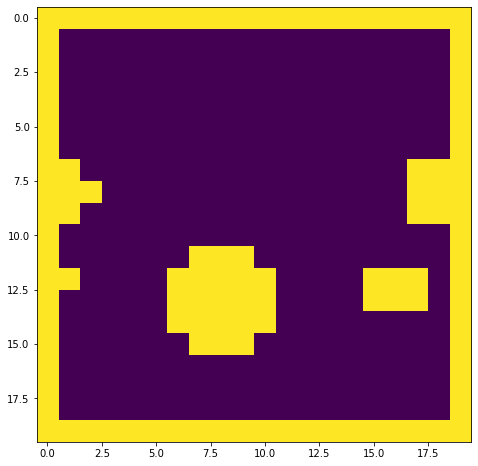

In [6]:
import matplotlib.pyplot as plt

x = logs["tasks"][0]
show_maze(x)

In [7]:
import argparse
parser = argparse.ArgumentParser(
    description='Reinforcement learning with Model-Agnostic Meta-Learning (MAML) - Test')

args = {
"config": "../maml-randomShapeMaze/config.json",
"policy": "../maml-randomShapeMaze/policy.th",

# Evaluation
"num_batches": 1,
"meta_batch_size": 1,

# Miscellaneous
"output": "maml-randomShapeMaze/results.npz",
"seed": None,
"num_workers": 1,
"device": ('cpu'),
}

height = 20
width = 20

In [8]:
try:
    gym.envs.register(
        id="RandomShapeMaze-v0",
        entry_point=MazeEnv,
        max_episode_steps=200,
        kwargs={"width": 50, "height": 50, "max_shapes": 50,
                "max_size": 8, "allow_overlap": False, "shape": None}
    )
except:
    print("environment already registered")

In [9]:
with open(args["config"], 'r') as f:
    config = json.load(f)
    if 'env-kwargs' not in config.keys(): config['env-kwargs'] = {}

env = gym.make(config['env-name'], **config['env-kwargs'])
env.close()

# configs:
fast_lr = config["fast-lr"]

In [10]:
def get_policy(policy_path):
    policy = get_policy_for_env(env,
                                hidden_sizes=config['hidden-sizes'],
                                nonlinearity=config['nonlinearity'])
    with open(policy_path, 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device(args["device"]))
        policy.load_state_dict(state_dict)
    return policy
        
policy = get_policy(args["policy"])
print(policy.layer1.bias)#.params["layer1.bias"])

Parameter containing:
tensor([-0.0089, -0.0374, -0.0183,  0.0424, -0.0430, -0.0114, -0.0245, -0.0180,
        -0.0237, -0.0515,  0.0081, -0.0362, -0.0335, -0.0011,  0.0931,  0.0008,
        -0.0638, -0.0151, -0.0378, -0.0031,  0.0154, -0.0074, -0.0332, -0.0041,
         0.0033,  0.0123, -0.0115,  0.0188,  0.0104, -0.0411, -0.0939, -0.0337],
       requires_grad=True)


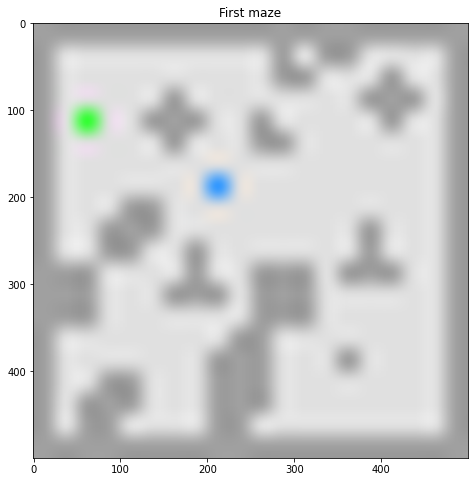

In [11]:
observations = env.reset()
img = env.render('rgb_array')
show_maze(img, "First maze")

In [12]:
def run_policy(env, observations=None, params=None):
    if observations.all == None:
        observations = env.reset()
    data = []
    path = [env.maze.objects.agent.positions[0]]
    count = 0
    reward = 0
    with torch.no_grad():
        while not (env.maze.objects.agent.positions == env.maze.objects.goal.positions) and count < 50:
            observations_tensor = torch.from_numpy(observations)
            pi = policy(observations_tensor, params=params)
            actions_tensor = pi.sample()
            actions = actions_tensor.cpu().numpy()

            new_observations, rewards, _, infos = env.step(actions)

            data.append({ "observations": observations, "actions": actions, "rewards": rewards })
            observations = new_observations
            path.append(env.maze.objects.agent.positions[0])
            count += 1
            reward += rewards
    return data, np.array(path), reward

In [31]:
def show_policy(env, params, title):
    observations = env.reset()
    maze_original = observations.reshape(height,width)
    data, path, reward = run_policy(env, observations, params)

    maze_original[path[:,0], path[:,1]] = 4
    maze_original[path[0,0], path[0,1]] = 2
    maze_original[path[-1,0], path[-1,1]] = 5
    print("Number of steps: ", len(path))
    show_maze(maze_original, title + " - reward = {0}".format(round(reward, 2)))

Number of steps:  51


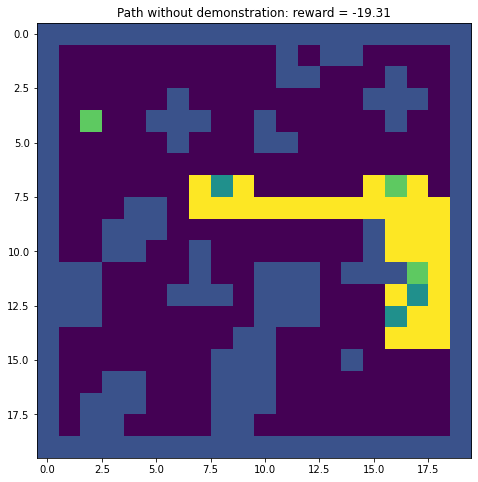

In [33]:
maze_original = observations.reshape(height,width)
data, path, reward = run_policy(env, observations)

maze_original[path[:,0], path[:,1]] = 4
maze_original[path[0,0], path[0,1]] = 2
maze_original[path[-1,0], path[-1,1]] = 3
print("Number of steps: ", len(path[:]))
show_maze(maze_original, "Path without demonstration: reward = {0}".format(round(reward, 2)))

## Update with example:

In [34]:
class Episodes:
    def __init__(self, batch_size, actions, rewards, observations):
        self.batch_size = batch_size
        self.actions = actions
        self.rewards = rewards
        self.observations = observations
        self.observation_shape = observations.shape[2:]
        self._lengths = None
        
    @property
    def lengths(self):
        if self._lengths is None:
            self._lengths = [len(rewards) for rewards in self.rewards]
        return self._lengths
    
    def __len__(self):
        return max(self.lengths)

In [35]:
def train_iter(policy, params=None):
    observations = env.reset()
    maze_image = env.get_image()
    impassable_array = env.unwrapped.maze.to_impassable()
    motions = env.unwrapped.motions
    start = env.unwrapped.maze.objects.agent.positions[0]
    goal = env.unwrapped.maze.objects.goal.positions[0]
    actions = dijkstra_solver(impassable_array, motions, start, goal)
    rewards = []
    observations = []
    for action in actions:
        observation, reward, _, infos = env.step(action)
        rewards.append(reward)
        observations.append(observation)
        
    actions      = torch.tensor([actions])
    rewards      = torch.tensor([rewards])
    observations = torch.tensor([observations])
    
    episodes = Episodes(1, actions, rewards, observations)
    
    loss = reinforce_loss(policy, episodes, params=params)
    params = policy.update_params(loss,
                                  params=params,
                                  step_size=fast_lr,
                                  first_order=True)
    print("Total rewards: ", np.array(sum(rewards[0])))
    print("Number of steps: ", len(rewards[0]))
    show_maze(maze_image, "dijkstra - reward = {0}".format((np.array(sum(rewards[0])), 2)))
    return params

Total rewards:  0.87
Number of steps:  14


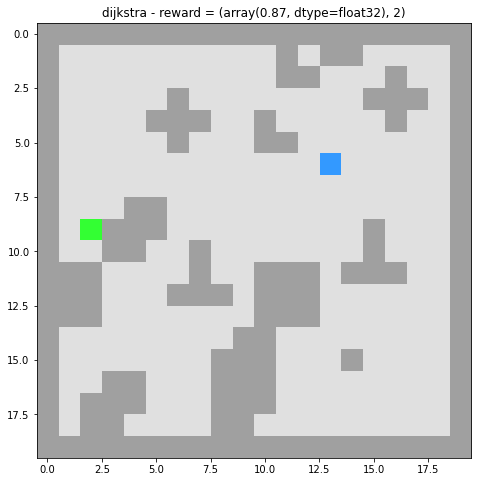

In [36]:
params1 = train_iter(policy)

## Check outcome after 1 iteration:

Number of steps:  51


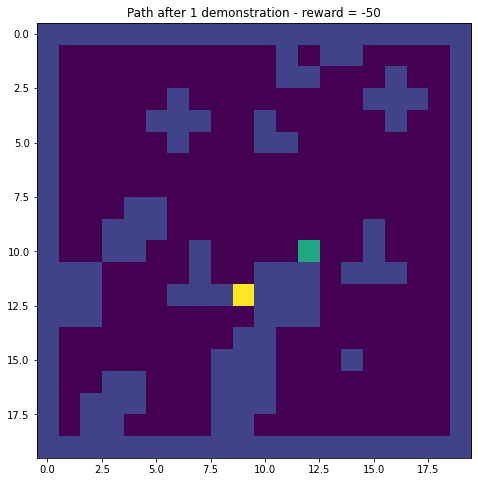

In [37]:
show_policy(env, params1, "Path after 1 demonstration")

## After 20 iterations

tensor([-0.1878, -0.1066,  0.1320,  0.1625], grad_fn=<SubBackward0>)
Total rewards:  0.93
Number of steps:  8


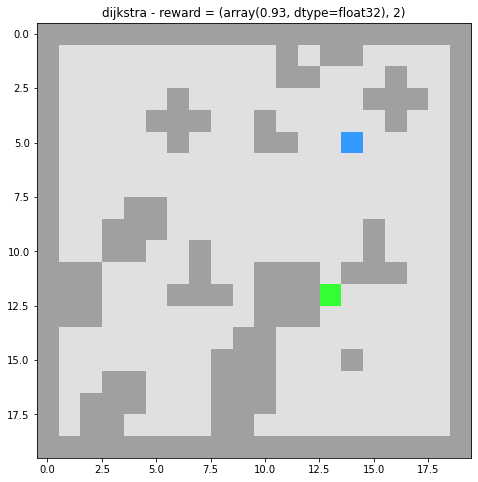

Number of steps:  51


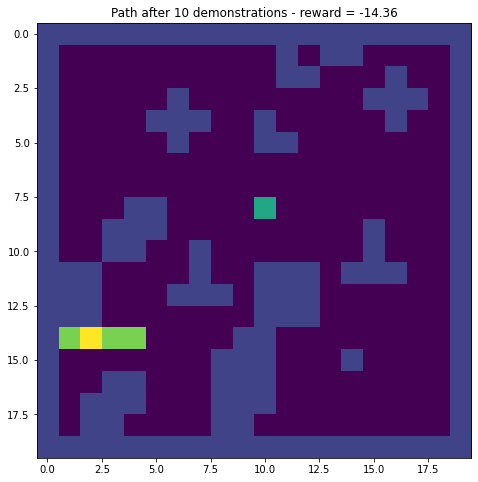

In [38]:
params2 = params1
for ii in range(1):
    print(params2["layer3.bias"])
    params2 = train_iter(policy, params2)

show_policy(env, params2, "Path after 10 demonstrations")